<div class="title">Practical Assignment: Support Vector Machines</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Carlos María Alaíz Gudín - Universidad Autónoma de Madrid</div>

---

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [1]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This cell imports the packages to be used (all of them quite standard except for `Utils`, which is provided with the notebook).

In [3]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from Utils import plot_dataset_clas, plot_svc

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the SVC class of `sklearn`.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

# SMO Algorithm

## Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

## SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

## Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

## Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

## Stopping Criteria

The algorithm will be terminated when a certain maximum number of iterations is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

## Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

## Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

# Implementation of the SVC

## Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs, each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X, y)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, X)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector

---
```python
predict(self, X)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `X`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

## Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

## Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [46]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

class MySVC():
  
    def __init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=100):
        # Assignment of the hyper-parameters (complete).
        self.C = C
        self.gamma=gamma
        self.tol=tol
        self.max_iter=max_iter
        self.kernel="rbf"
        # ...

    def fit(self, X, y):
        # Constants.
        n_pat = X.shape[0]
        n_dim = X.shape[1]

        # Options for gamma (for compatibility with sklean).
        if (self.gamma == "scale"):
            self.gamma = 1.0 / (n_dim * X.var())
        if (self.gamma == "auto"):
            self.gamma = 1.0 / n_dim

        # Initialization of the dual coefficients (named "a" instead of "alpha" for simplicity).
        self.a = np.zeros(n_pat)

        # Other initializations (complete).
        self.X = X
        self.y = y

        # Loop over the iterations.
        for it in range(self.max_iter):
            # Initializations (complete).
            a_old = np.array(self.a, copy=True)

            # Loop over the coefficients.
            for i in range(0, n_pat):
                j = self.choose_j(i)
                aj_old = self.a[j]

                # Update of the corresponding a[i] and a[j] values (complete).
                d = y[j] * (self.E_function(j) - self.E_function(i)) / self.k_function(i, j)
                L = self.L_bound(i, j, condition=(y[i]==y[j]))
                H = self.H_bound(i , j, condition=(y[i]==y[j]))
                self.a[j] = min(max(aj_old + d, L), H)
                self.a[i] += - y[i] * y[j] * (self.a[j] - aj_old)


            # Check of the stopping conditions (complete).
            if np.linalg.norm(self.a - a_old) < self.tol:
              break

        # Storage of the obtained parameters and computation of the intercept (complete).
        self.sv_cond = np.where((self.a > 0) & (self.a < self.C))[0]
        self.support_vectors_ = self.X[self.sv_cond]    
        self.b = self.b_intercept(self.sv_cond)
        self.coef_dual = self.y[self.sv_cond] * self.a[self.sv_cond]

        return self

    def decision_function(self, X):
        # Computation of the decision function over X (complete).
        # ...
        return self.output(X)+self.b

    def predict(self, X):
        # Computation of the predicted class over X (complete).
        # ...
        return np.sign(self.decision_function(X))

    # Sin considerar la intersección 
    def output(self, X):
        return (self.a * self.y) @ rbf_kernel(self.X, X, self.gamma)

    def E_function(self,i):
      return self.output(self.X[i].reshape(1,-1))[0] - self.y[i]

    def H_bound(self, i ,j ,condition):
      if condition:
        return min(self.C, self.a[i] + self.a[j])
      else:
        return min(self.C, self.C - self.a[i] + self.a[j])
    
    def L_bound(self, i ,j ,condition):
      if condition:
        return max(0, self.a[j] + self.a[i] - self.C)
      else: 
        return max(0, self.a[j] - self.a[i])
    
    def k_function(self, i, j):
      return (2*rbf_kernel(self.X[i].reshape(1,-1), self.X[j].reshape(1,-1), self.gamma)[0,0] - 
              rbf_kernel(self.X[i].reshape(1,-1), self.X[i].reshape(1,-1), self.gamma)[0,0] -
              rbf_kernel(self.X[j].reshape(1,-1), self.X[j].reshape(1,-1), self.gamma)[0,0])
    
    def b_intercept(self,k):
      return np.mean(self.y[k] - self.output(self.X[k]))

    # Auxiliary methods (complete if needed).
    def choose_j(self, i):
        v = np.arange(len(self.a))
        return np.random.choice(v[v != i])

    # ...

Se ha traducido las fórmulas y la teoría explicada para crear nuestro propio modelo SVC. Y a parte se ha analizado la función plot_svc() del paquete "Utils" para añadir los parametro necesarios aunque no se utilicen para entrenar el modelo como podría ser self.kernel, que al ser siempre rbf no es un parametro necesario, unicamente para la función plot_svc(). O para rescribir el nombre de ciertas variables para coincidir con las utilizadas en plot_svc() como support_vectors_

También se han introducido las funciones opcionales descritas en uno de los apartados anteriores y se ha añadido la funciones k_function que calcula el valor de k, todo esto para que este más limpio el código de la función fit.

# Experiments with the SVC

## Comparative with *scikit-learn*

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

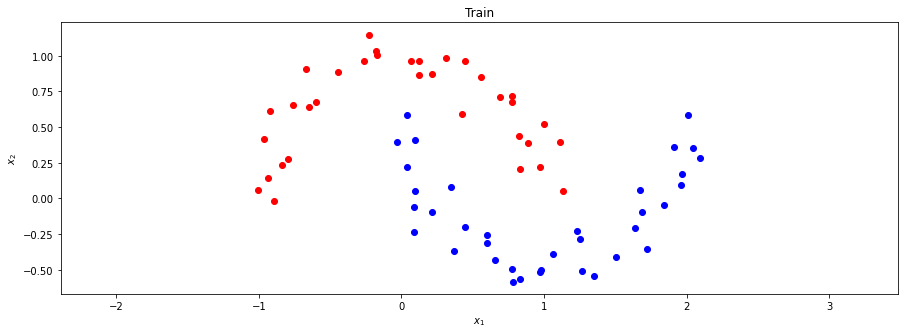

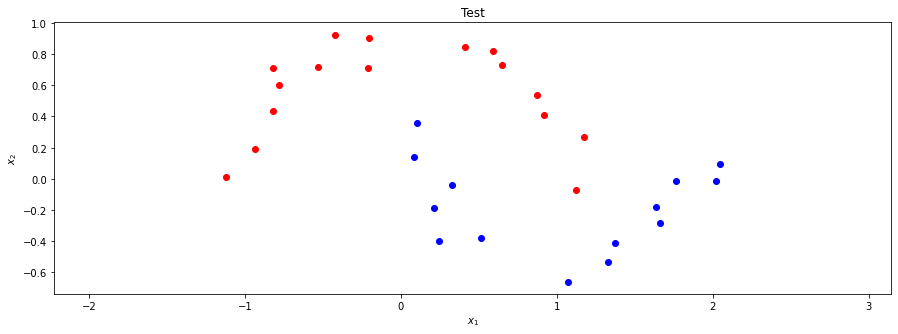

In [19]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

x, y = make_moons(noise=1e-1, random_state=seed)
y[y != 1] = -1

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title('Train'); plt.show()
plot_dataset_clas(x_te, y_te)
plt.title('Test'); plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of `sklearn` and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results. If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [50]:
C = 1
gamma = 'scale'

mySVC = MySVC(C=C, gamma=gamma)
sklearnSVC = SVC(C=C, gamma=gamma)

# Training of the models.
mySVC.fit(x_tr,y_tr)
sklearnSVC.fit(x_tr,y_tr)

# Scores of the two models.
scoreMySVC = mySVC.decision_function(x_te)
scoreSklearnSVC = sklearnSVC.decision_function(x_te)

# Prediction classes of the two models.
predictionMySVC = mySVC.predict(x_te)
predictionSklearnSVC = sklearnSVC.predict(x_te)

**Comparación de modelos**

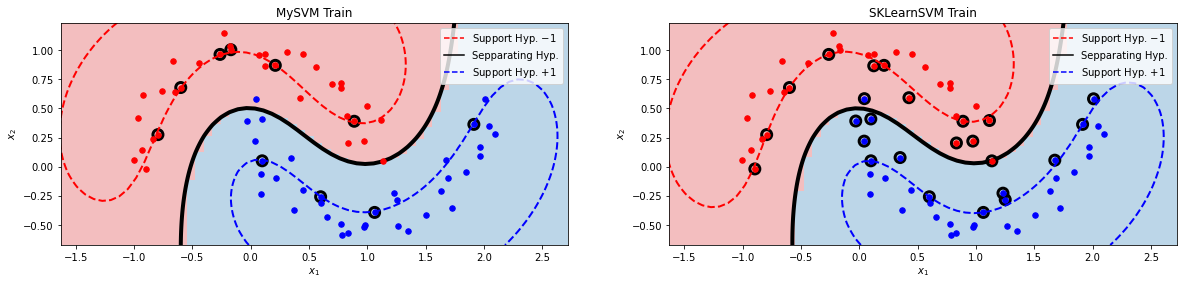

In [51]:
# Modelo que se generá del training

plt.subplots(figsize=(20,9))

plt.subplot(221)
plot_svc(x_tr, y_tr, mySVC)
plt.title("MySVM Train")

plt.subplot(222)
plot_svc(x_tr, y_tr, sklearnSVC)
plt.title("SKLearnSVM Train")

plt.show()

En los graficos de los dos modelos del svm, se pueden observar los hiperplanos (los de support y el de separación). También se pueden observar los support vectors, los cuales son los puntos marcados. Los dos modelos son visualmente idénticos lo único que el de sklearn clasifica un número mayor de puntos como support vectors.

**Decision function**

Para comparar las diferencias entre las funciones de decisión, podemos calcular el error medio absoluto de las diferencias entre las dos soluciones (scores), en que da igual lo distinto que sean los elementos se ponderan igual o con la raiz del error medio cuadrática para realizar una comparación más justa, al potenciar los errores grande y disminuir los pequeños.

Esta operación "np.where(scoreMySVC!=scoreSklearnSVC)" devuelve una tupla con el array y un elemento vacio y nos interesa unicamente el array filtrado.

In [ ]:
print("Cantidad elementos distintos =",len(np.where(scoreMySVC!=scoreSklearnSVC)[0]))
print("Elementos totales=",len(scoreMySVC))

Cantidad elementos distintos = 30
Elementos totales= 30


In [ ]:
print("MAE =",np.mean(np.abs(scoreMySVC-scoreSklearnSVC)))
print("MSE =",np.mean((scoreMySVC-scoreSklearnSVC)**2))

MAE = 0.02375148325897832
MSE = 0.0009374442556924266


Los resultados obtenidos de las dos funciones de decisión son todos distintos, pero por una diferencia mínima como se comprueba en el MAE y en el MSE.

**Predicciones**

In [ ]:
np.array_equal(predictionMySVC,predictionSklearnSVC)

True

Las predicciones realizadas por los dos modelos son idénticas.

Ahora se comprobara la probabilidad de acierto y fallo de cada modelo, que por la acción realizada anteriormente debe de ser idéntica

Esta operación "np.where(y_te==predictionMySVC)" devuelve una tupla con el array y un elemento vacio y nos interesa unicamente el array filtrado.

In [ ]:
print("MySVC prediction: ")
print("  Test succes =", len(np.where(y_te==predictionMySVC)[0])/len(y_te))
print("  Test failure =", len(np.where(y_te!=predictionMySVC)[0])/len(y_te))

MySVC prediction: 
  Test succes = 0.9666666666666667
  Test failure = 0.03333333333333333


In [ ]:
print("SklearnSVC prediction: ")
print("  Test succes =", len(np.where(y_te==predictionSklearnSVC)[0])/len(y_te))
print("  Test failure =", len(np.where(y_te!=predictionSklearnSVC)[0])/len(y_te))

SklearnSVC prediction: 
  Test succes = 0.9666666666666667
  Test failure = 0.03333333333333333


Los dos modelos tienen una tasa de acierto del 96% y del 3% de fallo.

## Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

**Extract the list of support vectors, explaining the followed approach.**

Los support vecotrs son puntos de datos que están más cerca del hiperplano y que influyen en la posición y la orientación del hiperplano y se utilizan para maximizar el margen del clasificador. Para ello tienen que 
cumplir que los elementos de α (alpha) correspondientes cada uno a un x (dato) se encuentran en el intervalo (0,C). 

Por tanto, aquellos puntos cuyo α esta en el rango (0,C) son los vectores de soporte que se encuentran en el hiperplano de soporte. 

Todo esto se puede ver programado en la función fit() del modelo en el apartado de almacenamiento de parametros.

Para verlo más visual se muestra una imagen del modelo con unicamente los puntos que son support vectors.



Support vectors =
 [[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.09841814  0.05019174]
 [ 1.06252195 -0.39226767]
 [ 0.88775478  0.38926482]
 [-0.1701044   1.00266984]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 1.91345677  0.3625312 ]]





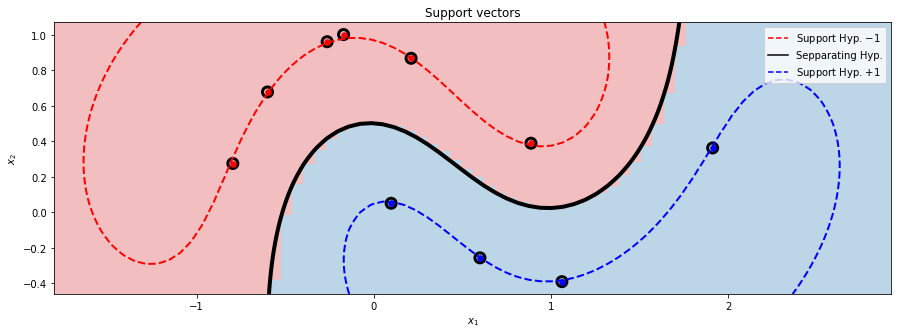

In [83]:
print('Support vectors =\n', mySVC.support_vectors_)

print("\n\n")
plot_svc(mySVC.support_vectors_, y_tr[mySVC.sv_cond], mySVC)
plt.title("Support vectors")
plt.show()

**Extract the list of training points bad and well classified, explaining the followed approach.**

Para ello utilizaremos la función predict() con los elementos de entrenamiento y se compararán con los valores esperados, luego los elementos bien y mal clasificados se dividiran por el total de datos de entrenaiento para obtener la proporción de cada uno.

In [93]:
predictEntr = mySVC.predict(X=x_tr)

bienClas = np.where(y_tr==predictEntr)[0]
print("Elementos bien clasificados= \n", x_tr[bienClas])
print("\n Proporción = ",len(bienClas)/len(x_tr))

malClas = np.where(y_tr!=predictEntr)[0]
print("\n\nElementos mal clasificados= \n", x_tr[malClas])
print("\n Proporción = ",len(malClas)/len(x_tr))

Elementos bien clasificados= 
 [[ 1.68792426 -0.0981035 ]
 [-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.9720389   0.21902698]
 [ 0.65462368 -0.43432386]
 [ 1.26610851 -0.50682361]
 [ 0.09841814  0.05019174]
 [ 0.56155158  0.85122387]
 [ 0.42448524  0.59130712]
 [ 1.06252195 -0.39226767]
 [-0.66625776  0.90611844]
 [-0.1785632   1.03583077]
 [ 2.04744488  0.35091483]
 [-0.9623992   0.41442543]
 [ 0.83169282 -0.56838816]
 [ 0.82483944  0.43424825]
 [ 0.44598685 -0.20238606]
 [-0.92514894  0.61051612]
 [ 0.06999164  0.96156857]
 [ 0.88775478  0.38926482]
 [ 1.23082636 -0.22735139]
 [ 1.63556454 -0.20700992]
 [-0.1701044   1.00266984]
 [ 0.96998002 -0.5188826 ]
 [ 1.115151    0.39583904]
 [ 1.96456314  0.09457656]
 [ 0.12278879  0.8649236 ]
 [ 1.13567114  0.04975262]
 [-0.22651016  1.14840109]
 [ 0.21729751 -0.09860236]
 [-0.8367634   0.23609495]
 [ 1.67526518  0.05558455]
 [ 0.09103819 -0.06146458]
 [ 0.09012959 -0.23445768]
 [ 0.44663896  0.96634251]
 [ 0.21104358  0.8686439

A continueción se mostraran de forma visual tanto los bien clasificados y los mal clasificados.

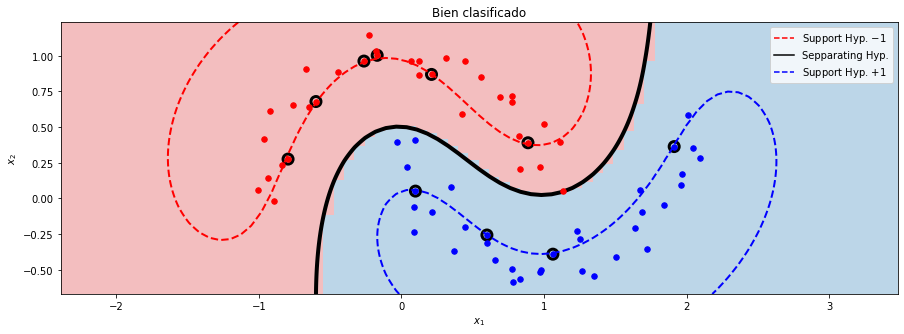

/content/Utils.py:455: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, zz, colors=["r", "k", "b"], levels=[-1, 0, 1], linestyles=["--", "-", "--"], linewidths=[2, 4, 2])


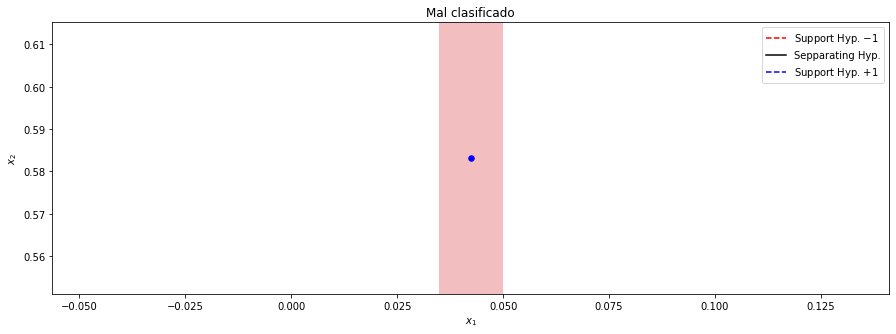

In [75]:
plot_svc(x_tr[bienClas], y_tr[bienClas], mySVC)
plt.title("Bien clasificado")
plt.show()

print("\n\n")

#Cuando solo muestra un elemento el plot_svc() puede no funcionar correctamente
plot_svc(x_tr[malClas], y_tr[malClas], mySVC)
plt.title("Mal clasificado")
plt.show()

**Extract the list of training points that lie over the supporting hyperplanes**

In [84]:
print("Elementos que se encuentran derca de los hiperplanos de apoyo =\n",mySVC.support_vectors_)

Elementos que se encuentran derca de los hiperplanos de apoyo =
 [[-0.7952664   0.2746645 ]
 [ 0.59973944 -0.25787141]
 [ 0.09841814  0.05019174]
 [ 1.06252195 -0.39226767]
 [ 0.88775478  0.38926482]
 [-0.1701044   1.00266984]
 [ 0.21104358  0.86864391]
 [-0.59960441  0.67856403]
 [-0.26285754  0.96232495]
 [ 1.91345677  0.3625312 ]]


Ahora se mostrarán de forma visual. Los puntos que estan cerca de los hiperplanos de apoyo son los support vestors, por las propiedades explicadas en el primer aparatado de esta serie de preguntas.

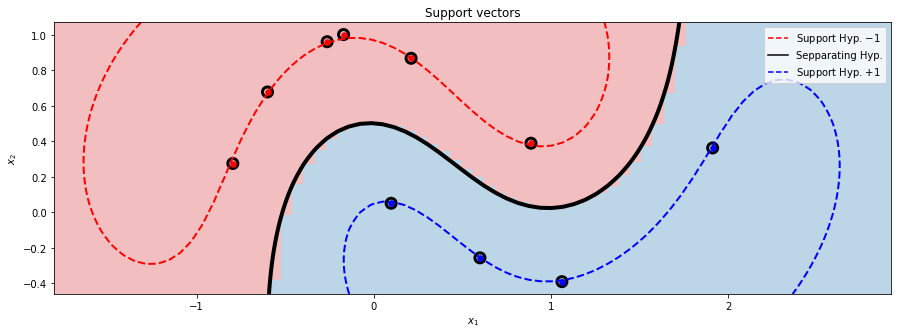

In [81]:
plot_svc(mySVC.support_vectors_, y_tr[mySVC.sv_cond], mySVC)
plt.title("Support vectors")
plt.show()

**Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified**

Para ello buscaremos los elementos bien clasificados, los cuales tienen un α con el mismo valor que C.

Lista de los elemento que cumplen con lo dicho =
 [[ 0.9720389   0.21902698]
 [ 0.42448524  0.59130712]
 [ 1.23082636 -0.22735139]
 [ 1.115151    0.39583904]
 [ 0.12278879  0.8649236 ]
 [ 1.13567114  0.04975262]
 [ 1.67526518  0.05558455]
 [-0.03147581  0.39140976]
 [ 1.25022826 -0.2826266 ]
 [ 2.00729148  0.58188871]
 [ 0.04062784  0.21890576]
 [ 0.83174596  0.20326404]
 [ 0.09781582  0.4090848 ]
 [-0.89675203 -0.01943427]
 [ 0.34875151  0.07811214]]





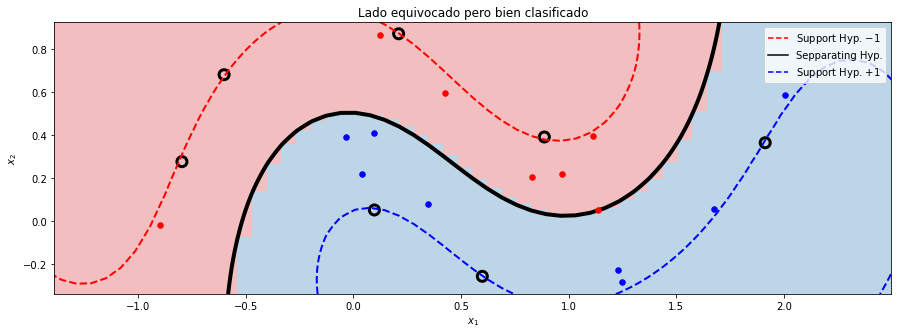

In [101]:
filtradoC = np.where(mySVC.a==C)[0]
elementsC = mySVC.predict(x_tr[filtradoC])
bienClasC = filtradoC[np.where(elementsC==y_tr[filtradoC])[0]]
print("Lista de los elemento que cumplen con lo dicho =\n",x_tr[bienClasC])
print("\n\n")
plot_svc(x_tr[bienClasC], y_tr[bienClasC], mySVC)
plt.title("Lado equivocado pero bien clasificado")
plt.show()

**What are the conditions over the dual coefficients  αi  that characterize the previous lists (if any)?**

La condición que caracteriza las anteriores listas es la siguiente: 0 ≤ α ≤ C. A partir de este aspecto podemos obtener todo lo relacionado a los support vectors.